In [29]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the dictionary mapping shape names to numerical labels
shape2number = {'circle': 0, 'square': 1, 'triangle': 2, 'pentagon': 3}

# Define the path to the dataset
dataset_path = 'Imagefusion_Dataset'

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor()  # Convert to tensor
])

class SingleImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(img_dir))
        self.labels = [self.load_label(os.path.join(label_dir, f"{os.path.splitext(img)[0]}.txt")) for img in self.image_files]

    def load_label(self, label_path):
        with open(label_path, 'r') as file:
            label = file.readline().strip()
        return shape2number[label]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# Create datasets for each image folder
label_dir = os.path.join(dataset_path, 'label')  # Assuming the labels folder is named 'labels'
img1_dataset = SingleImageDataset(os.path.join(dataset_path, 'img', 'img1'), label_dir, transform)
img2_dataset = SingleImageDataset(os.path.join(dataset_path, 'img', 'img2'), label_dir, transform)
img3_dataset = SingleImageDataset(os.path.join(dataset_path, 'img', 'img3'), label_dir, transform)

# Split datasets into training and testing sets
def split_dataset(dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return random_split(dataset, [train_size, test_size])

img1_train, img1_test = split_dataset(img1_dataset)
img2_train, img2_test = split_dataset(img2_dataset)
img3_train, img3_test = split_dataset(img3_dataset)

# Create data loaders
batch_size = 40
img1_train_loader = DataLoader(img1_train, batch_size=batch_size, shuffle=True)
img1_test_loader = DataLoader(img1_test, batch_size=batch_size, shuffle=False)
img2_train_loader = DataLoader(img2_train, batch_size=batch_size, shuffle=True)
img2_test_loader = DataLoader(img2_test, batch_size=batch_size, shuffle=False)
img3_train_loader = DataLoader(img3_train, batch_size=batch_size, shuffle=True)
img3_test_loader = DataLoader(img3_test, batch_size=batch_size, shuffle=False)

class LeNet5(nn.Module):
    def __init__(self, num_classes=4):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)  # 3 input channels for RGB images
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16*6*6, 120)  # Adjusted input size to 16*8*8
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [30]:
# Function to perform training and evaluation
def run_experiment(train_loader, test_loader, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, train_loader, criterion, optimizer, epochs=100)
    accuracy = evaluate_model(model, test_loader)
    return accuracy

# Train and evaluate on img1
print("Training and evaluating on img1:")
model1 = LeNet5(num_classes=4)
accuracy_img1 = run_experiment(img1_train_loader, img1_test_loader, model1)
print('Accuracy on img1:', accuracy_img1)

# Train and evaluate on img2
print("Training and evaluating on img2:")
model2 = LeNet5(num_classes=4)
accuracy_img2 = run_experiment(img2_train_loader, img2_test_loader, model2)
print('Accuracy on img2:', accuracy_img2)

# Train and evaluate on img3
print("Training and evaluating on img3:")
model3 = LeNet5(num_classes=4)
accuracy_img3 = run_experiment(img3_train_loader, img3_test_loader, model3)
print('Accuracy on img3:', accuracy_img3)

Training and evaluating on img1:
Epoch 1/100, Loss: 1.3834166884422303
Epoch 2/100, Loss: 1.3653368830680848
Epoch 3/100, Loss: 1.3418354570865632
Epoch 4/100, Loss: 1.2566810965538024
Epoch 5/100, Loss: 1.1716988325119018
Epoch 6/100, Loss: 1.1706124663352966
Epoch 7/100, Loss: 1.1000100672245026
Epoch 8/100, Loss: 1.042282611131668
Epoch 9/100, Loss: 1.0385566979646683
Epoch 10/100, Loss: 0.987696397304535
Epoch 11/100, Loss: 0.9368215650320053
Epoch 12/100, Loss: 0.9364133775234222
Epoch 13/100, Loss: 0.8932770371437073
Epoch 14/100, Loss: 0.8799770057201386
Epoch 15/100, Loss: 0.8444756209850312
Epoch 16/100, Loss: 0.8456706255674362
Epoch 17/100, Loss: 0.8386605650186538
Epoch 18/100, Loss: 0.8197568237781525
Epoch 19/100, Loss: 0.8209322601556778
Epoch 20/100, Loss: 0.7840207040309906
Epoch 21/100, Loss: 0.7691056370735169
Epoch 22/100, Loss: 0.7455288112163544
Epoch 23/100, Loss: 0.7430459678173065
Epoch 24/100, Loss: 0.7895086735486985
Epoch 25/100, Loss: 0.7404975950717926
Epo

In [31]:
import numpy as np
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import os

# Define the path to the dataset
dataset_path = 'Imagefusion_Dataset'

# Define the folders for each sensor and fused images
img1_folder = os.path.join(dataset_path, 'img', 'img1')
img2_folder = os.path.join(dataset_path, 'img', 'img2')
img3_folder = os.path.join(dataset_path, 'img', 'img3')
fused_folder = os.path.join(dataset_path, 'fused')

# Create the fused folder if it doesn't exist
if not os.path.exists(fused_folder):
    os.makedirs(fused_folder)

# Get a list of all image files in each folder
img1_files = [f for f in os.listdir(img1_folder) if f.endswith('.png')]
img2_files = [f for f in os.listdir(img2_folder) if f.endswith('.png')]
img3_files = [f for f in os.listdir(img3_folder) if f.endswith('.png')]

# Methods
def average_fusion(image1, image2, image3):
    if len(image1.shape) == 3:
        image1 = image1.mean(axis = 2)
    if len(image2.shape) == 3:
        image2 = image2.mean(axis = 2)
    if len(image3.shape) == 3:
        image3 = image3.mean(axis = 2)
    return (image1 + image2 + image3) / 3

def max_selection_fusion(image1, image2, image3):
    if len(image1.shape) == 3:
        image1 = image1.max(axis = 2)
    if len(image2.shape) == 3:
        image2 = image2.max(axis = 2)
    if len(image3.shape) == 3:
        image3 = image3.max(axis = 2)
    return np.maximum(np.maximum(image1, image2), image3)

def min_selection_fusion(image1, image2, image3):
    if len(image1.shape) == 3:
        image1 = image1.min(axis = 2)
    if len(image2.shape) == 3:
        image2 = image2.min(axis = 2)
    if len(image3.shape) == 3:
        image3 = image3.min(axis = 2)
    return np.minimum(np.minimum(image1, image2), image3)

fused_images= []

# Apply Fusion to all images
for i, (img1_file, img2_file, img3_file) in enumerate(zip(img1_files, img2_files, img3_files)):
    image1 = imread(os.path.join(img1_folder, img1_file)).astype(float)
    image2 = imread(os.path.join(img2_folder, img2_file)).astype(float)
    image3 = imread(os.path.join(img3_folder, img3_file)).astype(float)

    fused_average = average_fusion(image1, image2, image3)
    fused_max = max_selection_fusion(image1, image2, image3)
    fused_min = min_selection_fusion(image1, image2, image3)

    # Store the fused average images in the list
    fused_images.append(fused_max)

    # Save the fused average images to the specified directory
    fused_image_filename = os.path.join(fused_folder, f'{str(i).zfill(5)}.png')
    imsave(fused_image_filename, fused_average.astype(np.uint8))

""""
    # Show Result
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Image No. {str(i+1).zfill(5)}', fontsize=16)

    # First Row
    plt.subplot(2, 3, 1)
    plt.title('Gradient')
    plt.axis('off')
    plt.imshow(image1.astype(np.uint8))

    plt.subplot(2, 3, 2)
    plt.title('Noise')
    plt.axis('off')
    plt.imshow(image2.astype(np.uint8), cmap=None)

    plt.subplot(2, 3, 3)
    plt.title('Spotlight')
    plt.axis('off')
    plt.imshow(image3.astype(np.uint8), cmap=None)

    # Second Row
    plt.subplot(2, 3, 4)
    plt.title('Average Fusion')
    plt.axis('off')
    plt.imshow(fused_average.astype(np.uint8), cmap=None)

    plt.subplot(2, 3, 5)
    plt.title('Max Selection Fusion')
    plt.axis('off')
    plt.imshow(fused_max.astype(np.uint8), cmap=None)

    plt.subplot(2, 3, 6)
    plt.title('Min Selection Fusion')
    plt.axis('off')
    plt.imshow(fused_min.astype(np.uint8), cmap=None)

    plt.tight_layout()
    plt.show()
"""

'"\n    # Show Result\n    plt.figure(figsize=(12, 8))\n    plt.suptitle(f\'Image No. {str(i+1).zfill(5)}\', fontsize=16)\n\n    # First Row\n    plt.subplot(2, 3, 1)\n    plt.title(\'Gradient\')\n    plt.axis(\'off\')\n    plt.imshow(image1.astype(np.uint8))\n\n    plt.subplot(2, 3, 2)\n    plt.title(\'Noise\')\n    plt.axis(\'off\')\n    plt.imshow(image2.astype(np.uint8), cmap=None)\n\n    plt.subplot(2, 3, 3)\n    plt.title(\'Spotlight\')\n    plt.axis(\'off\')\n    plt.imshow(image3.astype(np.uint8), cmap=None)\n\n    # Second Row\n    plt.subplot(2, 3, 4)\n    plt.title(\'Average Fusion\')\n    plt.axis(\'off\')\n    plt.imshow(fused_average.astype(np.uint8), cmap=None)\n\n    plt.subplot(2, 3, 5)\n    plt.title(\'Max Selection Fusion\')\n    plt.axis(\'off\')\n    plt.imshow(fused_max.astype(np.uint8), cmap=None)\n\n    plt.subplot(2, 3, 6)\n    plt.title(\'Min Selection Fusion\')\n    plt.axis(\'off\')\n    plt.imshow(fused_min.astype(np.uint8), cmap=None)\n\n    plt.tight_layo

In [ ]:
class SingleSensorDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(img_dir))
        self.labels = [self.load_label(os.path.join(label_dir, f"{os.path.splitext(img)[0]}.txt")) for img in self.image_files]

    def load_label(self, label_path):
        if not os.path.exists(label_path):  
            raise FileNotFoundError(f"Label file not found: {label_path}")  # Debugging step

        with open(label_path, 'r') as file:
            label = file.readline().strip()
        return shape2number[label]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        label = self.labels[idx]

        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, label

# Define the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

class ImageFusionDataset(Dataset):
    def __init__(self, img1_dir, img2_dir, img3_dir, label_dir, transform=None):
        self.img1_dir = img1_dir
        self.img2_dir = img2_dir
        self.img3_dir = img3_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(img1_dir))
        self.labels = [self.load_label(img) for img in self.image_files]  # ✅ Only pass filename

    def load_label(self, img_name):
        label_path = os.path.join(self.label_dir, f"{os.path.splitext(img_name)[0]}.txt")  # ✅ Corrected path
        if not os.path.exists(label_path):  
            raise FileNotFoundError(f"Label file not found: {label_path}")  # Debugging step

        with open(label_path, 'r') as file:
            label = file.readline().strip()
        return shape2number[label]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.img1_dir, self.image_files[idx])
        img2_path = os.path.join(self.img2_dir, self.image_files[idx])
        img3_path = os.path.join(self.img3_dir, self.image_files[idx])
        label = self.labels[idx]

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        img3 = Image.open(img3_path)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        combined_img = torch.cat((img1, img2, img3), dim=0)
        return combined_img, label

dataset_path = "Imagefusion_Dataset"  

img1_dir = os.path.join(dataset_path, 'img', 'img1')
img2_dir = os.path.join(dataset_path, 'img', 'img2')
img3_dir = os.path.join(dataset_path, 'img', 'img3')
label_dir = os.path.join(dataset_path, 'label')  # ✅ This is correct

dataset1 = SingleSensorDataset(img1_dir, label_dir, transform)
dataset2 = SingleSensorDataset(img2_dir, label_dir, transform)
dataset3 = SingleSensorDataset(img3_dir, label_dir, transform)

# Split the datasets into training and testing sets
train_size = int(0.8 * len(dataset1))
test_size = len(dataset1) - train_size

train_dataset1, test_dataset1 = random_split(dataset1, [train_size, test_size])
train_dataset2, test_dataset2 = random_split(dataset2, [train_size, test_size])
train_dataset3, test_dataset3 = random_split(dataset3, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

train_loader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=False)

# Create the fused dataset for the fused model
fused_dataset = ImageFusionDataset(img1_dir, img2_dir, img3_dir, label_dir, transform)
train_dataset_fused, test_dataset_fused = random_split(fused_dataset, [train_size, test_size])

train_loader_fused = DataLoader(train_dataset_fused, batch_size=batch_size, shuffle=True)
test_loader_fused = DataLoader(test_dataset_fused, batch_size=batch_size, shuffle=False)


# Define the LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=4, input_channels=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, stride=1, padding=2)  # Adjusted for 1 input channel (grayscale)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16*6*6, 120)  # Adjusted input size to 16*6*6
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Instantiate models for each sensor dataset
model1 = LeNet5(num_classes=4)
model2 = LeNet5(num_classes=4)
model3 = LeNet5(num_classes=4)
model_fusion = LeNet5(num_classes=4, input_channels=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
optimizer_fusion = optim.Adam(model_fusion.parameters(), lr=0.001)

# Train the models

print("Training model 1...")
train_model(model1, train_loader1, criterion, optimizer1, epochs=100)
print("Training model 2...")
train_model(model2, train_loader2, criterion, optimizer2, epochs=100)
print("Training model 3...")
train_model(model3, train_loader3, criterion, optimizer3, epochs=100)
print("Training fused model...")
train_model(model_fusion, train_loader_fused, criterion, optimizer_fusion, epochs=100)



Training model 1...
Epoch 1/100, Loss: 1.3850075098184438
Epoch 2/100, Loss: 1.373026361832252
Epoch 3/100, Loss: 1.3595608381124644
Epoch 4/100, Loss: 1.3320808227245624
Epoch 5/100, Loss: 1.2831127460186298
Epoch 6/100, Loss: 1.1971730177219098
Epoch 7/100, Loss: 1.1618382288859441
Epoch 8/100, Loss: 1.1552633138803334
Epoch 9/100, Loss: 1.2025339236626258
Epoch 10/100, Loss: 1.1860182193609385
Epoch 11/100, Loss: 1.1370316468752348
Epoch 12/100, Loss: 1.1007267878605769
Epoch 13/100, Loss: 1.0898940975849445
Epoch 14/100, Loss: 1.0819918513298035
Epoch 15/100, Loss: 1.072713287977072
Epoch 16/100, Loss: 1.0432592126039357
Epoch 17/100, Loss: 1.0676968968831575
Epoch 18/100, Loss: 1.0651744558260992
Epoch 19/100, Loss: 1.0234415256060088
Epoch 20/100, Loss: 1.0080337386864882
Epoch 21/100, Loss: 0.9965798808978155
Epoch 22/100, Loss: 1.001216274041396
Epoch 23/100, Loss: 0.9616299775930551
Epoch 24/100, Loss: 0.9508884732539837
Epoch 25/100, Loss: 0.9653672667650076
Epoch 26/100, Los

In [33]:
# Evaluate the models
accuracy1 = evaluate_model(model1, test_loader1)
accuracy2 = evaluate_model(model2, test_loader2)
accuracy3 = evaluate_model(model3, test_loader3)
accuracy_fusion = evaluate_model(model_fusion, test_loader_fused)

print('Accuracy of model 1:', accuracy1)
print('Accuracy of model 2:', accuracy2)
print('Accuracy of model 3:', accuracy3)
print('Accuracy with low-level fusion:', accuracy_fusion)


Accuracy of model 1: 71.5
Accuracy of model 2: 65.5
Accuracy of model 3: 66.5
Accuracy with low-level fusion: 77.0


In [34]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

# Function to perform majority voting with tie breaker
def majority_voting(models, test_loader):
    model1, model2, model3, model_fusion = models
    model1.eval()
    model2.eval()
    model3.eval()
    model_fusion.eval()

    correct = 0
    total = 0
    predictions_all = []

    with torch.no_grad():
        for images, labels in test_loader:
            batch_size = images.size(0)
            predictions = torch.zeros(batch_size, dtype=torch.long)
            image1 = images[:, 0:1, :, :]
            image2 = images[:, 1:2, :, :]
            image3 = images[:, 2:3, :, :]

            output1 = model1(image1)
            output2 = model2(image2)
            output3 = model3(image3)
            output_fusion = model_fusion(images)

            _, predicted1 = torch.max(output1, 1)
            _, predicted2 = torch.max(output2, 1)
            _, predicted3 = torch.max(output3, 1)
            _, predicted_fusion = torch.max(output_fusion, 1)

            stacked_preds = torch.stack((predicted1, predicted2, predicted3), dim=1)

            for i in range(batch_size):
                vote_counts = torch.bincount(stacked_preds[i])
                max_votes = torch.max(vote_counts)
                candidates = torch.where(vote_counts == max_votes)[0]
                if len(candidates) > 1:
                    predictions[i] = predicted_fusion[i]  # Prioritize fused classifier in case of a tie
                else:
                    predictions[i] = candidates[0]

            predictions_all.extend(predictions.tolist())

            total += batch_size
            correct += (predictions == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, predictions_all

# List of your already trained models
models = [model1, model2, model3, model_fusion]

# Perform majority voting
accuracy_majority_voting_fusion, _ = majority_voting(models, test_loader_fused)

print('Accuracy with low and high level image fusion:', accuracy_majority_voting_fusion)


Accuracy with low and high level image fusion: 86.5


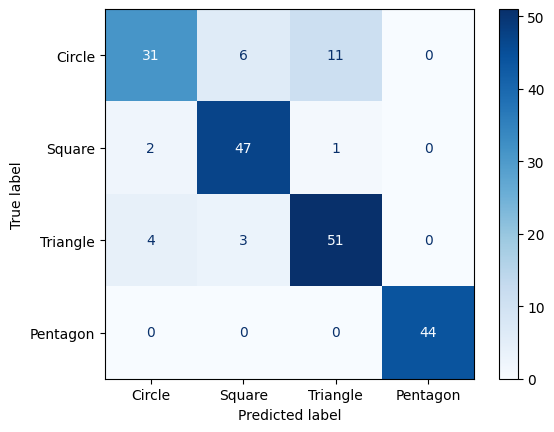

"save_model_weights(model1, 'model1_weights.pth')\nsave_model_weights(model2, 'model2_weights.pth')\nsave_model_weights(model3, 'model3_weights.pth')\nsave_model_weights(model_fusion, 'model_fusion_weights.pth')"

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(true_labels, predictions, classes):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def save_model_weights(model, path):
    torch.save(model.state_dict(), path)

# Extract true labels from test_loader_fused
true_labels = []
for _, labels in test_loader_fused:
    true_labels.extend(labels.numpy())

# Perform majority voting and store the predictions
accuracy_majority_voting_fusion, predictions_all = majority_voting(models, test_loader_fused) # Assign output of majority_voting to predictions_all

# Define class labels (replace with your actual class labels)
class_labels = ['Circle', 'Square', 'Triangle', 'Pentagon'] # Define class_labels


# Plot confusion matrix for majority voting fusion model
plot_confusion_matrix(true_labels, predictions_all, class_labels)

# Save model weights
"""save_model_weights(model1, 'model1_weights.pth')
save_model_weights(model2, 'model2_weights.pth')
save_model_weights(model3, 'model3_weights.pth')
save_model_weights(model_fusion, 'model_fusion_weights.pth')"""
